# No model strategy

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics as s

In [6]:
df_all = pd.read_csv("../data/BTCUSDT-minute-target-peak-features.csv")

In [352]:
df = df_all[-1000000:]

In [353]:
# df = df[70000:80000]

In [354]:
def set_limit(buy:bool, close:float, width:float, c=0.):
    """sets a new limit price point"""
    if buy:
        return close*(1-(width+c)/1000)
    else:
        return close*(1+(width+c)/1000)
def oscillator(buy: bool, close: float, btc:float, busd:float, max_val=100):
    """returns number between 1 and 10 to boost binr or sinr to dissuade"""
    if buy:
        return max(((btc/(btc+busd))-0.3)*max_val, 0)
    else:
        return max(((busd/(btc+busd))-0.3)*max_val, 0)

In [355]:
btc = 0.001
busd = 50.
amt = 10. #Amount of money per each buy and sell
bl = None #buying limit
sl = None #selling limit
plot = [] #[None, 30848.32, None]
acc = [] #accumulated wealth: busd + btc in USD
usd = []
blimit = [] # For plotting
slimit = []
binr = 1 #buys in a row
sinr = 1
tslb = 0 #time since last buy
tsls = 0
btc_plot = []

for i in range(len(df)):
    close = df.iloc[i].close
    high = df.iloc[i].high
    low = df.iloc[i].low
    width = df.iloc[i].volatility_dc_wband_10
    
    if bl and low<bl and busd>=amt: #buy
        btc += amt*0.999/bl
        busd -= amt
        plot.append(bl)
        bl = set_limit(True, close, width, binr*oscillator(True, close, btc*close, busd))
        binr += 1
        sinr = 1
        tslb = 0
    elif sl and high>sl and btc*high>=amt: #sell
        btc -= amt/sl
        busd += amt*0.999
        plot.append(-sl)
        sl = set_limit(False, close, width, sinr*oscillator(False, close, btc*close, busd))
        sinr += 1
        binr = 1
        tsls = 0
    else:
        plot.append(None)
        tslb += 1
        tsls += 1
        if bl != None and sl != None:
            bl += (close-bl)*0.001*min(tslb/5000, 1) #min(busd/(btc*close+1), 10)
            sl -= (sl-close)*0.001*min(tsls/5000, 1) #min((btc*close)/(busd+1), 10)

    usd.append(busd)
    blimit.append(bl)
    slimit.append(sl)
    acc.append(busd + btc*close)
    btc_plot.append(btc)
    
    
    bl = set_limit(True, close, width, 5) if bl == None else bl
    sl = set_limit(False, close, width, 5) if sl == None else sl

    


In [356]:
print(acc[-1])
print((list(df.close)[-1]-list(df.close)[0])/list(df.close)[0])
print((acc[1]-acc[0])/acc[0])

92.59308153021591
3.6451332967648935
-9.360308622746055e-05


0.17387035008252077
0.03682877275461654


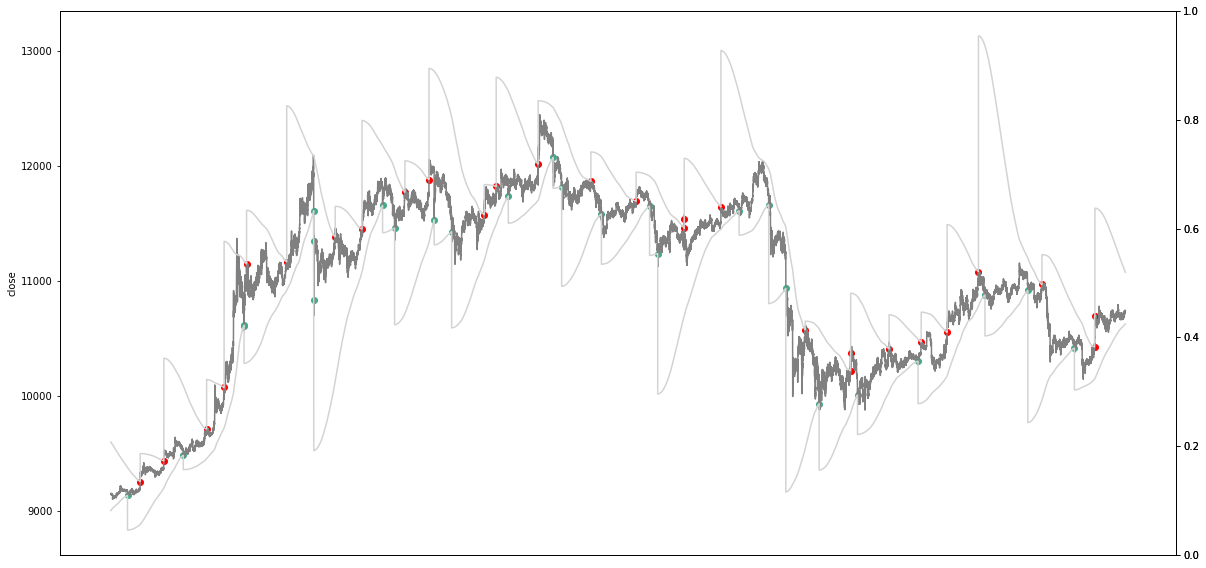

In [363]:
a = 400000
b = 500000

# 70000-80000, 15-30
fig,ax = plt.subplots(figsize=(20, 10))

plot_buy = list(map(lambda x: None if x == None or x<0 else x, plot[a:b]))
plot_sell = list(map(lambda x: None if x == None or x>0 else -x, plot[a:b]))


ax.scatter(range(b-a), 
            plot_buy,
            color="#43aa8b")

ax.scatter(range(b-a), 
            plot_sell,
            color="red")

ax.set_xlabel("time")
ax.set_ylabel("close")
ax.plot(
        list(df.close)[a:b],
        color="gray")


ax1 = ax.twinx()
# ax1.plot(acc[a:b])
# ax1.plot(usd[a:b])
ax.plot(blimit[a:b], color="lightgray")
ax.plot(slimit[a:b], color="lightgray")

ax2 = ax.twinx()
# ax2.plot(list(btc_plot)[a:b])


ax.tick_params(labelbottom=False)
ax.axes.xaxis.set_visible(False)

print((list(df.close)[b-1]-list(df.close)[a])/list(df.close)[a])
print((acc[b-1]-acc[a])/acc[a])

In [132]:
def transact(close:float, width:float, buy:bool):
    """buys"""
    global btc
    global amt
    global busd
    global bl
    global sl
    global transaction
    global cooldown
    global bc
    global sc
    global binr
    global sinr
    btc += amt/bl if buy else -amt/sl
    busd -= amt*1.002 if buy else -amt*0.998
    bl = transact_price(bl, width, buy, binr) if buy else bl
    sl = sl if buy else transact_price(sl, width, buy, sinr)
    transaction = close if buy else -close
    if buy:
        bc += cooldown
        binr += 1
        sinr = 2 if sinr >=4 else sinr - 2  ### Change this to ###
    else:
        sc += cooldown
        binr = 2 if binr >=4 else binr - 2
        sinr += 1
    
def transact_price(close:float, width:float, buy:bool, c:int):
    """creates the new transaction price"""
    return (1.-((width+c)/100.))*close if buy else (1.+((width+c)/100.))*close
def bitcoin_value(close:float):
    """returns the current value of bitcoins"""
    global btc
    return btc*close
def regress_speed(buy:bool, btc_val:float, busd:float):
    if buy:
        # Want, if buy, slow down if already bought a lot, so more btc_val than busd
        # Therefore, fast if more busd than btc_val
        return min(((busd+1)/(btc_val+1), 10))/1000
    else:
        return min(((btc_val+1)/(busd+1), 10))/1000
        

In [133]:
btc = 0.
busd = 100.
amt = 10. #Amount of money per each buy and sell
bl = None #buying limit
sl = None #selling limit
cooldown = 120 #Cooldown limit
bc = 0 #buying cooldown
sc = 0 #selling cooldown
plot = [] #[None, 30848.32, None]
total = [] #Total transactions
acc = [] #accumulated wealth: busd + btc in USD
transaction = None
usd = []
blimit = [] # For plotting
slimit = []
binr = 2 #Buys in a row
sinr = 2 #sells in a row

initiate = False

In [134]:
for i in range(len(df)):
    transaction = None
    initiate = False
    close = df.iloc[i].close
    high = df.iloc[i].high
    low = df.iloc[i].low
    width = df.iloc[i].volatility_dc_wband_10
    rate = df.iloc[i].trend_sma_50_rate_log
    if bl and low<=bl and busd>=amt and bc==0:                                  #limit buy order
        transact(close, width, True)
    elif sl and high>=sl and bitcoin_value(high)>=amt and sc==0:                                #limit sell order
        transact(close, width, False)
    elif not bl and busd>=amt and bc==0: #Machine says buy
        tp = transact_price(close, width, True, binr)
        bl = tp
        initiate = True
    elif not sl and bitcoin_value(close)>=amt and sc==0: #Machine says buy
        tp = transact_price(close, width, False, sinr)
        sl = tp
        initiate = True
    plot.append(transaction)
    if transaction is not None:
#         print(f"t: {transaction}, btc = {round(btc, 5)}, busd = {busd}, bc = {bc}, sc = {sc}, bl = {round(bl, 5) if bl is not None else None}, sl = {round(sl, 5) if sl is not None else None}, time = {i}")
        total.append(transaction)
    if not initiate:
        sl = sl-(sl-close)*0.0005 if sl != None and rate <= 0.5 else sl 
        bl = bl+(close-bl)*0.0005 if bl != None and rate >= 0.5 else bl
    acc.append(busd + bitcoin_value(close))
    usd.append(busd)
    bc -= 1 if bc > 0 else 0
    sc -= 1 if sc > 0 else 0
    blimit.append(bl)
    slimit.append(sl)


In [135]:
acc[-1]

7.879335808255076

In [136]:
len(total)

37

-0.0334286660424482
-0.0023983888753494396


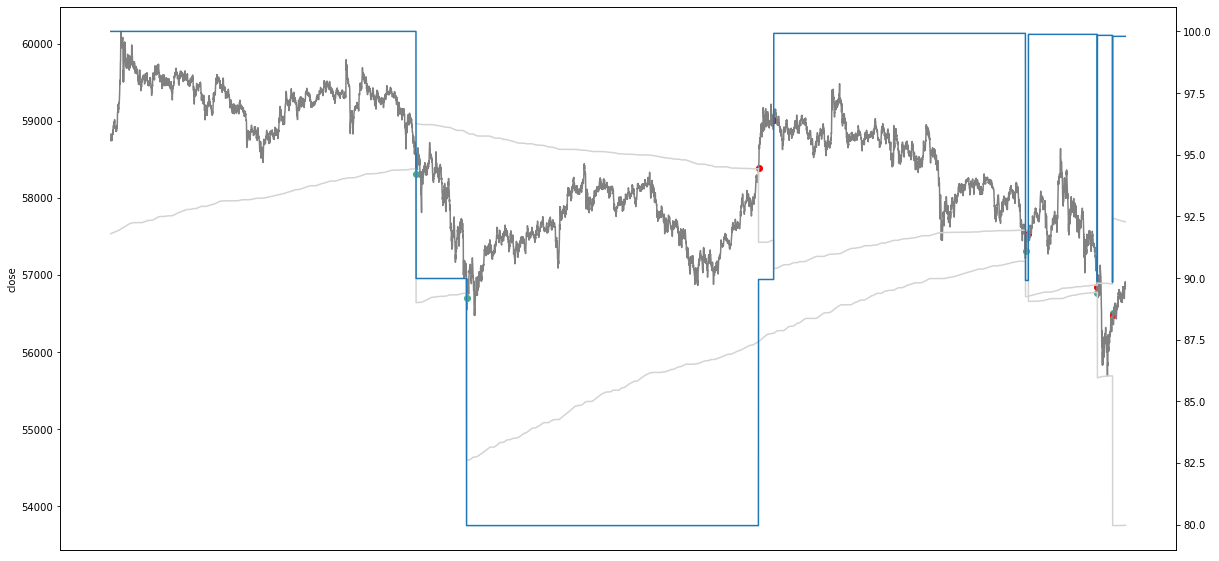

In [143]:
a = 10000
b = 18000
fig,ax = plt.subplots(figsize=(20, 10))

plot_buy = list(map(lambda x: None if x == None or x<0 else x, plot[a:b]))
plot_sell = list(map(lambda x: None if x == None or x>0 else -x, plot[a:b]))


ax.scatter(range(b-a), 
            plot_buy,
            color="#43aa8b")

ax.scatter(range(b-a), 
            plot_sell,
            color="red")

ax.set_xlabel("time")
ax.set_ylabel("close")
ax.plot(
        list(df.close)[a:b],
        color="gray")


ax1 = ax.twinx()
# ax1.plot(acc[a:b])
ax1.plot(usd[a:b])
ax.plot(blimit[a:b], color="lightgray")
ax.plot(slimit[a:b], color="lightgray")

# ax2 = ax.twinx()
# ax2.plot(list(df.trend_sma_50_rate_log)[a:b])


ax.tick_params(labelbottom=False)
ax.axes.xaxis.set_visible(False)

print((list(df.close)[b-1]-list(df.close)[a])/list(df.close)[a])
print((acc[b-1]-acc[a])/acc[a])

(array([ 7695.,  8999., 10484., 10383., 10086., 10253., 11057., 11645.,
        10525.,  8873.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

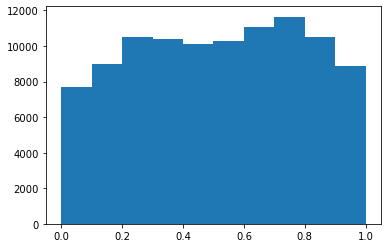

In [72]:
plt.hist(df.trend_sma_50_rate_log)